In [156]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import json
from collections import defaultdict
import random
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

## Settings

In [211]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30
THRESHOLD1 = 1
THRESHOLD2 = 4
THRESHOLD3 = 7

#### Tracks

In [207]:
data_folder = Path("/home/roberta/dataScience/01/algorithmicMethodsDataMining/hw4/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

#### Queries

In [203]:
data_folder = Path("/home/roberta/dataScience/01/algorithmicMethodsDataMining/hw4/query/")
queries = data_folder.glob("*.wav")

## Preprocessing

In [313]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## Audio signals

#### Tracks

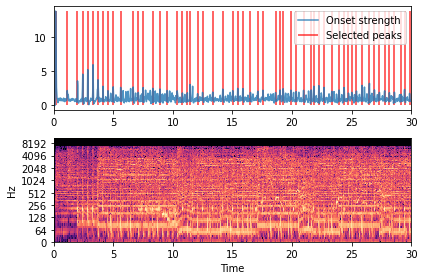

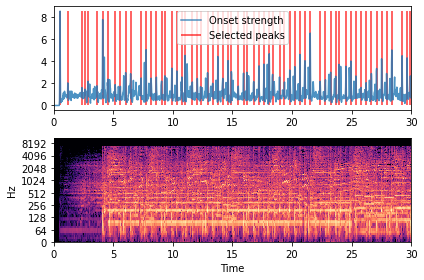

In [208]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)

#### Queries

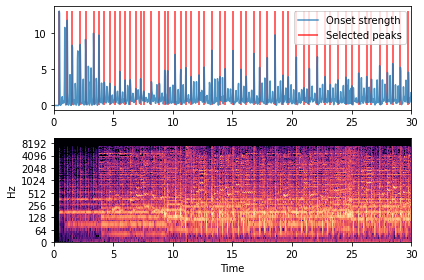

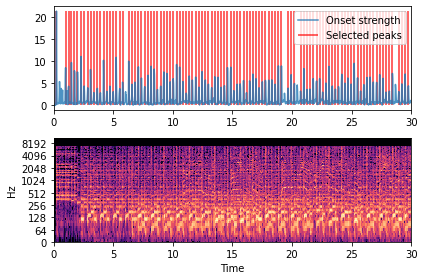

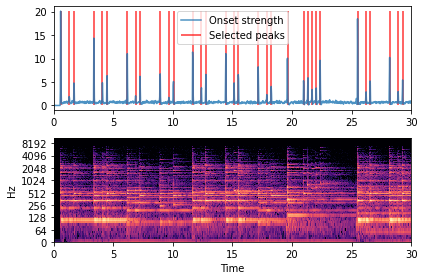

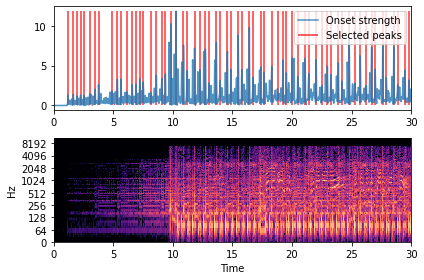

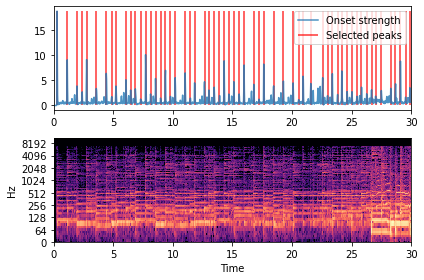

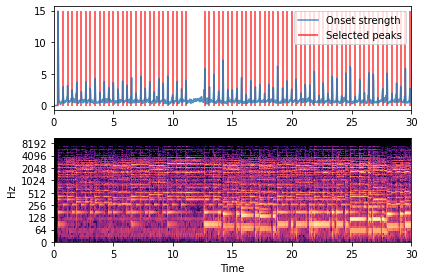

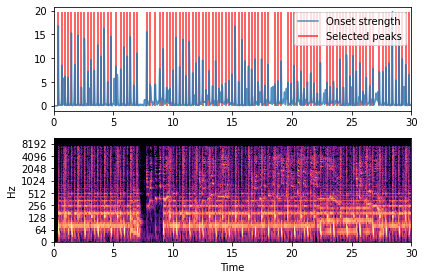

In [205]:
for idx, audio in enumerate(queries):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)

## Minhash

Create a dictionary with the shingles and save the tracks and queries names

In [168]:
def createShingles(tracks):
    
    tracks_names = {}
    shingles={} #ogni track in che indici ha i peaks
    
    for idx, audio in enumerate(tracks):
        track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
        shingles[idx] = peaks.tolist()
        tracks_names[idx] = audio
    
    return shingles, tracks_names

In [169]:
tracksShingles, tracksNames = createShingles(tracks)

In [172]:
queryShingles, queryNames = createShingles(queries)

Save the shingles dict into a json file

In [170]:
tracksShingles_file = open("tracksShingles.json", "w")
json.dump(tracksShingles, tracksShingles_file)
tracksShingles_file.close()

In [174]:
queryShingles_file = open("queryShingles.json", "w")
json.dump(queryShingles, queryShingles_file)
queryShingles_file.close()

Load the shingles file

In [171]:
tracksShingles_file = open("tracksShingles.json", "r")
tracksShingles = json.load(tracksShingles_file)

In [175]:
queryShingles_file = open("queryShingles.json", "r")
queryShingles = json.load(queryShingles_file)

Create the signature matrices with the minhash functions (tracks and query)

In [209]:
def minHash(tracksShingles, queryShingles):
    
    # Create signature Data Frames with 21 permutations
    tracksSignature = pd.DataFrame(columns=["track_{i}".format(i=i) for i in range(len(tracksShingles))],
                             index=[i for i in range(21)])
    querySignature = pd.DataFrame(columns=["query_{i}".format(i=i) for i in range(len(queryShingles))],
                             index=[i for i in range(21)])
    
    # Generate 21 permutations
    for i in range(21):
        rows = [i for i in range(1292)]
        random.shuffle(rows)
        
        # Create Data Frames with all 0s where columns are tracks/queries and rows are peaks
        dfTracks = pd.DataFrame(data=np.zeros((1292,len(tracksShingles))), 
                      columns=["track_{i}".format(i=i) for i in range(len(tracksShingles))],
                      index=[rows])
        dfQuery = pd.DataFrame(data=np.zeros((1292,len(queryShingles))), 
                      columns=["query_{i}".format(i=i) for i in range(len(queryShingles))],
                      index=[rows])
        
        # Insert 1 in the Data Frames if the peak is inside the track/query
        for track, trackPeaks in tracksShingles.items():
            dfTracks.loc[trackPeaks, "track_{i}".format(i=track)] = 1
        
        for query, queryPeaks in queryShingles.items():
            dfQuery.loc[queryPeaks, "query_{i}".format(i=query)] = 1
        
        # Form the signature matrices with the indeces of the first occurrence of the peak (first 1 value)
        for track in dfTracks.columns:
            for j, row in enumerate(list(dfTracks[track])):
                if row == 1:
                    tracksSignature.loc[i, track] = j
                    break
                    
        for query in dfQuery.columns:
            for j, row in enumerate(list(dfQuery[query])):
                if row == 1:
                    querySignature.loc[i, query] = j
                    break
    
    return tracksSignature, querySignature

In [182]:
minHashTracksSignature, minHashQuerySignature = minHash(tracksShingles, queryShingles)

Look at the tracks signature matrix

In [183]:
minHashTracksSignature

,track_0,track_1,track_2,track_3,track_4,track_5,track_6,track_7,track_8,track_9,...,track_1403,track_1404,track_1405,track_1406,track_1407,track_1408,track_1409,track_1410,track_1411,track_1412
0,4,4,36,24,13,17,18,5,10,19,...,29,36,2,15,19,0,36,32,17,28
1,32,3,13,1,7,20,25,17,56,13,...,14,121,4,6,3,7,11,51,4,12
2,0,63,0,7,5,24,11,2,7,1,...,10,10,31,0,47,27,33,1,9,66
3,34,26,87,5,2,38,22,3,38,4,...,36,11,6,60,21,20,6,16,1,7
4,29,27,35,12,9,1,65,40,29,19,...,0,38,24,17,44,35,20,0,7,0
5,19,78,8,16,0,19,0,24,3,3,...,3,23,8,31,25,13,111,4,13,64
6,21,17,9,5,28,0,3,4,37,1,...,32,14,16,35,1,0,49,7,8,0
7,29,16,28,19,15,23,24,21,18,18,...,18,39,17,0,35,26,9,7,5,10
8,29,93,19,21,17,12,5,6,33,4,...,15,11,0,13,34,1,45,2,0,101
9,7,16,7,26,27,8,2,11,14,2,...,6,46,28,4,20,24,2,6,14,11


Look at the query signature matrix

In [184]:
minHashQuerySignature

,query_0,query_1,query_2,query_3,query_4,query_5,query_6,query_7,query_8,query_9
0,55,56,0,15,7,29,11,15,11,50
1,9,55,17,3,10,26,0,6,3,23
2,4,17,13,0,10,7,4,0,13,13
3,18,17,139,8,6,25,7,60,5,4
4,27,4,68,3,12,12,8,17,64,4
5,6,1,27,1,1,89,16,31,4,6
6,30,7,79,2,5,5,15,35,7,11
7,0,7,23,4,4,70,0,0,10,1
8,13,4,125,69,28,86,10,13,0,11
9,14,38,62,32,8,97,12,4,26,13


Define the Locality Sensitive Hashing function to create the buckets

In [222]:
def LSH(tracksSignature, querySignature):
    
    Buckets = defaultdict(list)
    b = 3
    
    # For every band
    for i in range(0, len(querySignature.index), b):
        queryBand = querySignature[i:i+b]
        tracksBand = tracksSignature[i:i+b]
        
        # For every query of the band
        for query, queryPeaks in queryBand.items():
            
            # For every track in the band
            for track, trackPeaks in tracksBand.items():
                
                # If the query and track peaks are the same in the band, put them in the same bucket
                if set(queryPeaks) == set(trackPeaks):
                    Buckets[query].append(track)

    
    return Buckets

In [223]:
Buckets = LSH(minHashTracksSignature, minHashQuerySignature)

### Print the results for the queries

We use the variables THRESHOLD as the number of equal bands in the two signature matrices (tracks and queries).

In [312]:
thr1 = defaultdict(list)
thr2 = defaultdict(list)
thr3 = defaultdict(list)

for query in Buckets:

    query_id = int(query.split('_')[1])
    queryName = str(queryNames[query_id]).split('/')[-1].split('.')[0]
    
    tracks = Buckets[query]
    tracksCount = {}
    
    for track in tracks:
        
        count = tracks.count(track)
        tracksCount[track] = count
        
    for track in tracksCount:
        
        track_id = int(track.split('_')[1])
        artist = ' '.join(str(tracksNames[track_id]).split('/')[8].split('_')).title()
        trackName = ' '.join(str(tracksNames[track_id]).split('/')[-1].split('.')[0].split('-')[1].split('_'))
        
        if tracksCount[track] >= THRESHOLD1:
            thr1[queryName].append((trackName, artist))
        if tracksCount[track] >= THRESHOLD2:
            thr2[queryName].append((trackName, artist))
        if tracksCount[track] >= THRESHOLD3:
            thr3[queryName].append((trackName, artist))



print('For THRESHOLD =', THRESHOLD1, ':')           
for query in thr1:
    print(query, '-> ', ', '.join([' by '.join(song_artist) for song_artist in thr1[query]]))

print('\n')

print('For THRESHOLD =', THRESHOLD2, ':')      
for query in thr2:
    print(query, '-> ', ', '.join([' by '.join(song_artist) for song_artist in thr2[query]]))
    
print('\n')

print('For THRESHOLD =', THRESHOLD3, ':')      
for query in thr3:
    print(query, '-> ', ', '.join([' by '.join(song_artist) for song_artist in thr2[query]]))

For THRESHOLD = 1 :
track6 ->  Heartbreaker by Led Zeppelin, What Can You Lose by Madonna, 2 2 5 The Lukewarm  by Radiohead, Sweet the Sting by Tori Amos
track8 ->  American Idiot by Green Day, Sisters of the Moon by Fleetwood Mac
track9 ->  Somebody by Depeche Mode
track7 ->  Go Your Own Way by Fleetwood Mac
track4 ->  Ob by Beatles, The Morning Papers by Prince, Dixie Chicken by Garth Brooks
track3 ->  October by U2
track10 ->  Black Friday by Steely Dan, Undertow by Suzanne Vega
track5 ->  Karma Police by Radiohead, Private Ale by Green Day, View From A Hill by Roxette
track1 ->  Dream On by Aerosmith, Whatsername by Green Day, Express Yourself by Madonna
track2 ->  I Want To Break Free by Queen, The Beaches of Cheyenne by Garth Brooks, 4th of July by U2


For THRESHOLD = 4 :
track6 ->  Heartbreaker by Led Zeppelin
track8 ->  American Idiot by Green Day
track9 ->  Somebody by Depeche Mode
track7 ->  Go Your Own Way by Fleetwood Mac
track4 ->  Ob by Beatles
track3 ->  October by U2
t

We can see that for the first threshold the algorithm gives more than one correspondence, since only one equal band is sufficient to consider track and query similar.
If we raise the threshold instead, the algorithm becomes more strict, giving only one song per query.

# 2. Grouping songs together!

## 2.1 Getting your data!

#### Access to the data

In [4]:
echonest = pd.read_csv('/home/roberta/dataScience/01/algorithmicMethodsDataMining/hw4/echonest.csv')
tracks = pd.read_csv('/home/roberta/dataScience/01/algorithmicMethodsDataMining/hw4/tracks.csv')
features = pd.read_csv('/home/roberta/dataScience/01/algorithmicMethodsDataMining/hw4/features.csv')

Now i want to check the numbers of rows in each csv file

In [5]:
print(echonest.shape) #important to know this numbers so we can check unique data_id
print(features.shape)
print(tracks.shape)

(13129, 250)
(106574, 519)
(106574, 53)


Now lets try to merge this datasets

In [6]:
echonest.head() #lets first check this dataset

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


We think track_id is unique so we wanto to check if other datasets have this column

In [7]:
echonest.track_id.nunique() #as expected this column is unique

13129

Lets see data inside features dataset

In [8]:
features.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [9]:
features.track_id.nunique()

106574

The same with Track dataset

In [10]:
tracks.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [12]:
tracks.track_id.nunique()

106574

Now it is obvius that we will merge this datasets with unique column called track_id. As u can see this three datasets have different number of data. But in common when we join them we will get approximately 13k data. Lets check it.

In [13]:
df_echo = pd.DataFrame(echonest)
df_f = pd.DataFrame(features)
df_tr = pd.DataFrame(tracks)

In [14]:
df = df_echo.merge(df_f, on = 'track_id').merge(df_tr, on = 'track_id')

Lets check if it is merged correctly  

In [15]:
df.shape

(13129, 820)

In [16]:
df.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,NaN,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music


Everything is correct, so lets write some brief information about datasets here

- *Echonest*: has some information about the audio, ranks and social features, along with other numerical fields.  
- *Features dataset*: has a lot of data  about the tracks in numerical fields.  
- *Tracks*: it contains a lot of information on the album, the artist and the track.

## 2.2 Choose your features (variables)!


### Lets try to find a way to reduce the dimensionality (reduce the number of variables to work with). 
Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

Lets start with Echonest Dataset because it seems that this dataset have a lot of null values and it would be easier to cancell them first.

In [17]:
df_echo.shape

(13129, 250)

In [18]:
m_values = pd.DataFrame({'c_name':df_echo.columns,
                                 'p_missing': df_echo.isnull().sum()*100/len(df_echo)})

In [19]:
(m_values[m_values['p_missing'] > 0]).sort_values(by = 'p_missing')

,c_name,p_missing
metadata_artist_latitude,metadata_artist_latitude,25.584584
metadata_artist_location,metadata_artist_location,25.584584
metadata_artist_longitude,metadata_artist_longitude,25.584584
metadata_album_name,metadata_album_name,78.124762
ranks_artist_discovery_rank,ranks_artist_discovery_rank,78.482748
ranks_artist_familiarity_rank,ranks_artist_familiarity_rank,78.482748
ranks_artist_hotttnesss_rank,ranks_artist_hotttnesss_rank,78.490365
metadata_album_date,metadata_album_date,79.305355
ranks_song_hotttnesss_rank,ranks_song_hotttnesss_rank,83.197502
ranks_song_currency_rank,ranks_song_currency_rank,84.515195


As u can see here we have data that missing data almost to 80%, that is why we can remove them from all data

In [20]:
# lets first gather all not needed columns that we will drop later
not_used_columns = list(m_values[m_values['p_missing'] > 75].index)
not_used_columns

['metadata_album_date',
 'metadata_album_name',
 'ranks_artist_discovery_rank',
 'ranks_artist_familiarity_rank',
 'ranks_artist_hotttnesss_rank',
 'ranks_song_currency_rank',
 'ranks_song_hotttnesss_rank']

In [21]:
df_echo=df_echo.drop(not_used_columns, axis = 1)

In [22]:
df_echo.shape

(13129, 243)

In [23]:
df_echo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 243 entries, track_id to temporal_features_223
dtypes: float64(239), int64(1), object(3)
memory usage: 24.3+ MB


One more thing that i recognized here is that this three columns shows the same lach of data, so we can say that they have similar data.   
About the address of artist:  
metadata_artist_latitude	metadata_artist_latitude	25.584584  
metadata_artist_location	metadata_artist_location	25.584584  
metadata_artist_longitude	metadata_artist_longitude	25.584584

In [24]:
df_echo=df_echo.drop('metadata_artist_latitude',axis=1)
df_echo=df_echo.drop('metadata_artist_location',axis=1)
df_echo=df_echo.drop('metadata_artist_longitude',axis=1)

In [25]:
df_echo.shape

(13129, 240)

In [26]:
#to avoid this kind of error in PCA: 'could not convert string to float: 'AWOL''
#    I DECIDE TO DELETE STRING VALUES 
df_echo=df_echo.drop('metadata_artist_name',axis=1)
df_echo=df_echo.drop('metadata_release',axis=1)   

In [27]:
df_echo.shape

(13129, 238)

#### PCA

In [28]:
A = df_echo.values
A = scale(A)

In [29]:
pca = PCA(n_components = 100)
fit_trA = pca.fit_transform(A)
new_var1 = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 4)*100)
new_var1

array([11.37, 20.01, 24.9 , 28.14, 30.89, 33.47, 35.79, 38.06, 40.24,
       42.24, 44.12, 45.91, 47.68, 49.35, 50.97, 52.55, 53.96, 55.35,
       56.7 , 57.95, 59.14, 60.28, 61.33, 62.33, 63.32, 64.27, 65.2 ,
       66.09, 66.95, 67.78, 68.58, 69.32, 70.03, 70.73, 71.42, 72.11,
       72.78, 73.42, 74.06, 74.69, 75.3 , 75.87, 76.43, 76.97, 77.51,
       78.04, 78.56, 79.07, 79.58, 80.06, 80.53, 80.99, 81.45, 81.9 ,
       82.35, 82.79, 83.21, 83.63, 84.04, 84.44, 84.83, 85.22, 85.6 ,
       85.97, 86.33, 86.68, 87.03, 87.36, 87.69, 88.  , 88.3 , 88.59,
       88.87, 89.15, 89.42, 89.69, 89.95, 90.21, 90.46, 90.71, 90.95,
       91.18, 91.41, 91.64, 91.86, 92.08, 92.29, 92.49, 92.69, 92.89,
       93.09, 93.28, 93.46, 93.64, 93.82, 93.99, 94.16, 94.32, 94.48,
       94.64])

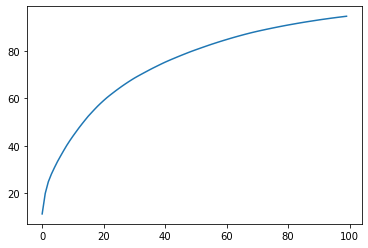

In [30]:
plt.plot(new_var1)

Here we can not choose how much we should choose components it is ovbios that it is between 40 and 60, lets try to decrease the number of components to see more

In [31]:
pca = PCA(n_components = 70)
fit_trA = pca.fit_transform(A)
new_var1 = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 4)*100)
new_var1

array([11.37, 20.01, 24.9 , 28.14, 30.89, 33.47, 35.79, 38.06, 40.24,
       42.24, 44.12, 45.91, 47.68, 49.35, 50.97, 52.55, 53.96, 55.35,
       56.7 , 57.95, 59.14, 60.28, 61.33, 62.33, 63.32, 64.27, 65.2 ,
       66.09, 66.95, 67.78, 68.58, 69.32, 70.03, 70.73, 71.42, 72.11,
       72.78, 73.42, 74.06, 74.69, 75.3 , 75.87, 76.43, 76.97, 77.51,
       78.04, 78.56, 79.07, 79.58, 80.06, 80.53, 80.99, 81.45, 81.9 ,
       82.34, 82.78, 83.2 , 83.62, 84.03, 84.43, 84.81, 85.19, 85.56,
       85.92, 86.28, 86.63, 86.98, 87.31, 87.63, 87.93])

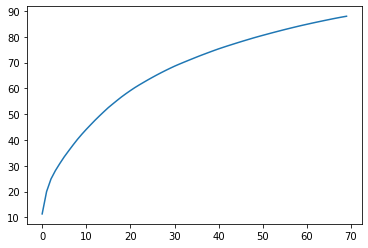

In [32]:
plt.plot(new_var1)

So we can say 50!

Now lets do the same with other two data sets 

### Features dataset

In [33]:
# lets check missing values
mvalues = df_f.isnull().sum()*100/len(df_f)
missing_values_df = pd.DataFrame({'cname':df_f.columns,
                                 'pmissing': mvalues})
missing_values_df[missing_values_df['pmissing']!=0]
# here u can see that in this dataset we do not have missing values, that is why lets do PCA

,cname,pmissing


### PCA

In [34]:
B = scale(df_f.values)

In [35]:
pca = PCA(n_components = 100)
fit_trB = pca.fit_transform(B)
new_var2 = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 4)*100)
new_var2

array([11.96, 18.75, 22.94, 26.3 , 29.26, 32.04, 34.56, 36.96, 39.23,
       41.33, 43.13, 44.71, 46.15, 47.51, 48.8 , 50.04, 51.12, 52.19,
       53.2 , 54.11, 54.97, 55.82, 56.62, 57.41, 58.14, 58.86, 59.55,
       60.21, 60.86, 61.47, 62.07, 62.65, 63.2 , 63.73, 64.23, 64.73,
       65.21, 65.68, 66.14, 66.59, 67.02, 67.45, 67.87, 68.29, 68.7 ,
       69.09, 69.48, 69.86, 70.23, 70.59, 70.94, 71.29, 71.62, 71.95,
       72.27, 72.58, 72.89, 73.19, 73.48, 73.77, 74.06, 74.34, 74.62,
       74.89, 75.16, 75.42, 75.68, 75.94, 76.2 , 76.45, 76.69, 76.93,
       77.17, 77.41, 77.64, 77.87, 78.1 , 78.33, 78.55, 78.77, 78.99,
       79.21, 79.42, 79.63, 79.84, 80.05, 80.25, 80.45, 80.65, 80.85,
       81.04, 81.23, 81.42, 81.61, 81.79, 81.97, 82.15, 82.33, 82.51,
       82.68])

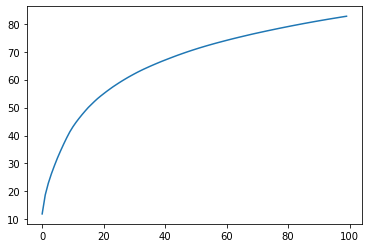

In [36]:
plt.plot(new_var2)

From 519 columns here we can say that we can decrease the number of all column till 80-90 preserving 80% of the total variance.

###  Tracks Dataset

In [37]:
df_tr = tracks.merge(df[['track_id']])
df_tr.shape

(13129, 53)

In [38]:
m_values = pd.DataFrame({'c_name':df_tr.columns,
                                 'p_missing': df_tr.isnull().sum()*100/len(df_tr)})
(m_values[m_values['p_missing'] > 0]).sort_values(by = 'p_missing')

,c_name,p_missing
track_title,track_title,0.007617
artist_date_created,artist_date_created,0.396070
track_license,track_license,0.487470
album_date_created,album_date_created,1.454795
album_type,album_type,2.307868
album_information,album_information,19.407419
artist_website,artist_website,20.245259
artist_bio,artist_bio,26.582375
track_genre_top,track_genre_top,28.745525
album_date_released,album_date_released,29.073044


In [39]:
variables_to_remove = list(m_values[m_values['p_missing']>0].c_name.index) 
df_tr = df_tr.drop(variables_to_remove, axis = 1)

In [40]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   track_id            13129 non-null  int64 
 1   album_comments      13129 non-null  int64 
 2   album_favorites     13129 non-null  int64 
 3   album_id            13129 non-null  int64 
 4   album_listens       13129 non-null  int64 
 5   album_tags          13129 non-null  object
 6   album_title         13129 non-null  object
 7   album_tracks        13129 non-null  int64 
 8   artist_comments     13129 non-null  int64 
 9   artist_favorites    13129 non-null  int64 
 10  artist_id           13129 non-null  int64 
 11  artist_name         13129 non-null  object
 12  artist_tags         13129 non-null  object
 13  set_split           13129 non-null  object
 14  set_subset          13129 non-null  object
 15  track_bit_rate      13129 non-null  int64 
 16  track_comments      13

In this case we do not need to use PCA, and we also can remove some columns of data because the fact that they are not needed further  
For example:  
- _track_id_: id of each track
- _album comments_: categorical value in which more than 80% of the total dataset has album comments.
- _album_favorites_, _album_id_, _album_tags_, _album_tracks_, _artist_comments_, _artist_favorites_, _artist_id_, _artis_name_, _artist_tags_, _set_split_, _set_subset_, _track_bit_rate_, _track_comments_: all are categorical variables
- _track_date_created_: removed as it's a date.

In [41]:
remove = ['track_id','album_comments','album_id','album_tags','album_title',
                  'artist_id','artist_name','artist_tags','set_split','set_subset',
                  'track_bit_rate','track_comments','track_date_created','track_genres','track_genres_all','track_tags']
df_tr = df_tr.drop(remove, axis = 1)

In [42]:
df_tr.shape

(13129, 10)

### We will use PCA to show the graph

In [43]:
C = df_tr.values
C = scale(C)

In [44]:
pca = PCA(n_components = 10)
df_trC = pca.fit_transform(C)
new_var3 = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 4)*100)
new_var3

array([ 37.29,  54.37,  68.12,  78.  ,  86.09,  92.24,  96.01,  97.54,
        98.83, 100.  ])

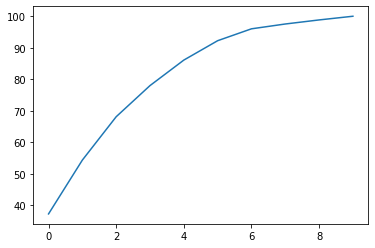

In [45]:
plt.plot(new_var3)

### FINAL TABLE

In [46]:
echo_Reducted = pd.DataFrame(fit_trA[:,:50])
for cols in echo_Reducted.columns:
    echo_Reducted.rename(columns = {cols:'Comp_y_'+str(cols)},inplace = True)

In [47]:
F_Reducted = pd.DataFrame(fit_trB[:,:86])  
for cols in F_Reducted.columns:
    F_Reducted.rename(columns = {cols:'Comp_x_'+str(cols)},inplace = True)

In [48]:
track_Reducted = pd.DataFrame(df_trC[:,:5])
for cols in track_Reducted.columns:
    track_Reducted.rename(columns = {cols:'Comp_z_'+str(cols)},inplace = True)

In [49]:
df_final = echo_Reducted.join(F_Reducted).join(track_Reducted)

In [50]:
df_final.insert(0,'track_id',df.loc[:,'track_id'])

In [51]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 142 entries, track_id to Comp_z_4
dtypes: float64(141), int64(1)
memory usage: 14.2 MB


In [52]:
df_final.shape

(13129, 142)

In [69]:
df_final

,track_id,Comp_y_0,Comp_y_1,Comp_y_2,Comp_y_3,Comp_y_4,Comp_y_5,Comp_y_6,Comp_y_7,Comp_y_8,...,Comp_x_81,Comp_x_82,Comp_x_83,Comp_x_84,Comp_x_85,Comp_z_0,Comp_z_1,Comp_z_2,Comp_z_3,Comp_z_4
0,2,0.754163,-1.710971,0.187051,0.476739,-1.410173,0.900424,-1.244107,0.868130,-0.612973,...,-0.165502,0.185534,1.024474,-0.213396,-0.010264,-0.096624,0.169828,-0.372131,-0.457243,-0.504436
1,3,2.636104,-4.166050,2.514985,-0.425144,0.003283,0.137694,1.570448,0.240276,-1.497112,...,-0.142789,-0.258935,-0.637231,-0.101540,-0.273544,-0.189604,0.074650,-0.362819,-0.093573,-0.456982
2,5,1.353418,-4.540633,2.437525,-0.021089,-0.964160,0.719371,1.517666,-0.644502,0.661399,...,-1.260098,-0.341230,1.582821,0.269915,-0.543685,-0.048305,0.119385,-0.124355,-0.155402,-0.231244
3,10,6.453293,-1.179631,0.790231,1.015266,1.136816,0.001680,-2.755197,2.248501,2.009491,...,-0.288167,-0.529062,0.471361,-0.637129,1.180816,7.049712,4.938425,-0.247179,-0.662143,0.595016
4,134,-2.943066,-5.531688,2.897130,-0.601768,0.572799,0.775426,0.006400,-0.618406,-0.406182,...,0.572504,-0.612117,0.841579,-0.305316,1.165791,-0.129853,0.081141,-0.230402,-0.191617,-0.343364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,2.723792,-4.615080,-1.264452,0.439221,-2.726077,1.930201,2.915029,0.980335,0.615470,...,0.276166,-0.265186,0.942319,-0.314879,-0.011727,0.728273,0.864857,0.707490,0.187519,0.122500
13125,124862,0.253671,-5.102224,1.536712,4.334304,-3.110184,2.792551,2.523940,-1.814717,0.178032,...,-0.101659,0.259881,0.529202,-0.512311,0.264040,-0.053869,0.102033,0.676972,0.128038,0.099015
13126,124863,2.872722,-4.516451,-0.936710,0.420447,-2.125131,3.726328,0.944013,0.634812,0.408704,...,0.461208,-1.574730,-1.476949,0.195846,0.209991,-0.118053,0.064442,0.624957,0.811290,0.131603
13127,124864,-0.179762,0.381387,-4.048943,-2.093550,-0.940870,1.023490,2.778115,-0.738642,1.980750,...,1.237147,-0.485872,0.058939,-0.690893,0.119808,-0.038507,0.066090,0.820374,0.424950,0.276135


In [70]:
df_final.iloc[:,1:2 ].values

array([[ 0.75416289],
       [ 2.63610389],
       [ 1.35341843],
       ...,
       [ 2.87272217],
       [-0.17976161],
       [-4.40541541]])

### 2.3 Clustering!

#### 1. Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class.

In [53]:
def KMeans(X, y, max_num = 80):
    ind_centroids = random.sample(range(len(X)),y)
    centroids = X[ind_centroids, :]
    p_clusters = [np.full(len(X), -1)]
    clusters = np.full(len(X), -1)
    distance = np.array([np.linalg.norm(X - centroids[i], axis = 1) for i in range(y)]).T
    clusters = np.argmin(distance, axis = 1)
    count = 0
    while (clusters != p_clusters[-1]).any() and (count <= max_num):
        p_clusters.append(clusters)
        for j in range(y):
            centroids[j] = np.mean(X[clusters==j,:], axis=0)
        distance = np.array([np.linalg.norm(X - centroids[i], axis = 1) for i in range(y)]).T
        clusters = np.argmin(distance, axis = 1)
        count+=1
    return clusters, centroids,count

#### 2. Find an optimal number of clusters. Use at least two different methods. In case that your algorithms provide different optimal K's, select one of them and explain why you chose it.

### 1st Method: Elbow Method

In [54]:
def elbow_num(X, clusters, c):
    C = np.array([c[k] for k in clusters])
    dist = np.linalg.norm(X-C, axis = 1)
    S = np.sum(dist)
    return S

In [55]:
def elbow_m(X, k_min, k_max):
    inertia = []
    K = []
    for k in range(k_min, k_max + 1):
        clusters, c, count  = KMeans(X,k)
        S = elbow_num(X, clusters, c)
        inertia.append(S)
        K.append(k)
        print(k)
    plt.plot(K, inertia)
    plt.show()
    return K, inertia

In [64]:
km= KMeans(n_clusters=5, init = 'k-means++', random_state=0).fit(df_final)
labels = km.labels_
centroids = km.cluster_centers_
X = df_final.iloc[:,1:2 ].values

NameError: name 'y' is not defined

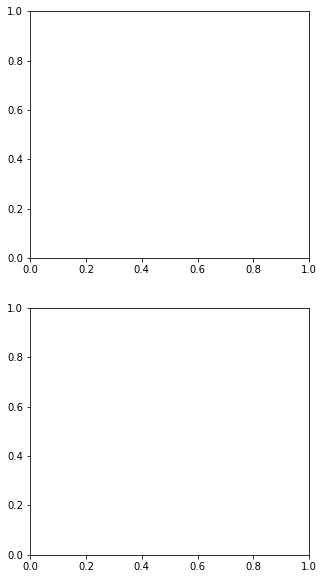

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
axs[0].scatter(X, s=4, c=y)
axs[0].set_title("ground-truth labels")
axs[1].scatter(X, s=4, c=labels)
axs[1].set_title("k-means labels")
plt.show()

print(silhouette_score(X, labels, metric="euclidean"))

In [93]:
X = df_final.iloc[:,1:2 ].values
centroids, cluster = KMeans(X, 2)

ValueError: too many values to unpack (expected 2)

# 3. Algorithmic questions

You are given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.

For example, if

A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4
the algorithm should output: (7, -3), (-2, 6), (2, 2), (3, 1).

In [1]:
import itertools

def pairs(A, s):
    result = []

    for j in itertools.combinations(A, 2):
        if sum(j) == s:
            result.append(j)
            
    return result


A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]
s = 4

print(pairs(A, s))

[(7, -3), (-2, 6), (2, 2), (1, 3)]
